[![Made withJupyter](https://img.shields.io/badge/Made%20with-Jupyter-orange?style=for-the-badge&logo=Jupyter)](https://jupyter.org/try)

# MNIST generation with DC-WGAN

This notebook is freely inspired by the [TensorFlow tutorial](https://www.tensorflow.org/tutorials/generative/dcgan) on Deep Convolutional Generative Adversarial Network (DC-GAN). The code is written using the [Keras Sequential API](https://www.tensorflow.org/guide/keras/sequential_model) to build the adversarial networks and the [`tf-gen-models` package](https://pypi.org/project/tf-gen-models/) to implement and run the training procedure.

## What are WGANs?

Generative Adversarial Networks [[1](https://arxiv.org/abs/1406.2661)] are a powerful class of _generative models_ based on the simultaneous training of two neural networks:

*  the **discriminator network** ($D$) is trained to distinguish the generator output from the reference dataset;
* while the **generator network** ($G$) is trained to reproduce the reference dataset trying to fake the discriminator.

The goal is that $D$ optimally discriminates on the origin of the two samples, and simultaneously the training procedure for $G$ is to maximize the _probability_ of $D$ making a mistake. This framework corresponds to a **minimax two-player game** [[1](https://arxiv.org/abs/1406.2661)].

Traditional GAN systems suffer from many issues, particularly during the training phase:

* the generator _may collapse_ producing only a single sample or a small family of very similar samples (**mode collapse**);
* the two players _may oscillate_ during training rather than converging to a fixed point;
* if _imbalance_ between the two agents occurs, then the system is incapable of learning at all.

All these issues are related to the **vanishing gradient** problem [[2](https://arxiv.org/abs/1701.04862)]. In order to avoid this and recover the information brought by the gradient, we need to change the loss function originally proposed by Ian Goodfellow [[1](https://arxiv.org/abs/1406.2661)] moving to a _distance measurement_ robust against the vanishing gradient problem. Then the new loss function is the so-called **Wasserstein distance** [[3](https://arxiv.org/abs/1701.07875)].

## Mathematical details

The generator $G(z)$, fed by elements $z$ sampled according to a known distribution $p_z$ (typically gaussian), maps the **latent space** $\mathcal{Z}$ to the reference dataset $\mathcal{X}$, inducing a distribution $p_\rm{gen}$ trained to match with the target distribution $p_\rm{ref}$. The discriminator $D(x)$ outputs a single scalar, readable as the **score** that $x$ comes from the reference dataset rather than $G$. Hence, the optimization problem corresponds to train $D$ to maximize the distance between the _reference score_ and the _generator score_, and simultaneously training $G$ to minimize the same quantity.

In order to avoid _vanishing gradient issues_, the optimization problem for the two networks is based on the **Wasserstein distance** [[4](https://link.springer.com/book/10.1007/978-3-540-71050-9)]:

<center>$W \left ( p_{\rm{ref}}, p_{\rm{gen}} \right ) = \displaystyle{\sup_{\| f \|_L \le 1}} \left ( \, \mathbb{E}_{x \sim p_{\rm{ref}}} [f(x)] - \mathbb{E}_{x \sim p_{\rm{gen}}} [f(x)] \, \right )$</center>

where the supremum is over all the 1-Lipschitz functions $f : \mathcal{X} \to \mathbb{R}$. Note that if we replace $\| f \|_L \le 1$ with $\| f \|_L \le K$ (consider K-Lipschitz for some constant $K$), then we end up with $K \cdot W \left ( p_{\rm{ref}}, p_{\rm{gen}} \right )$ that ensures robustness to the optimization problem described above.

Defining the **loss function** $\mathcal{L}_{\rm{WGAN}}$ as follows

<center>$\mathcal{L}_{\rm{WGAN}} (\theta_d, \theta_g) = \mathbb{E}_{x \sim p_\rm{ref}} \left[ D_{\theta_d}(x) \right] - \mathbb{E}_{z \sim p_\rm{z}} \left[ D_{\theta_d}(G_{\theta_g}(z)) \right]$</center>

the _minimax game_ can be written in this form:

<center>$\displaystyle{\min_{\theta_g \in \mathbb{R}} \, \max_{\theta_d \in \mathcal{W}} \, \mathcal{L}_{\rm{WGAN}} (\theta_d, \theta_g)}$</center>

where the _lipschitzianity_ of $D$ is ensured requiring that its parameters $\theta_d$ lie in a compact space $\mathcal{W}$. Hence, WGAN clamps the discriminator weights to a fixed box (say $\mathcal{W} = [-0.01, 0.01]^\ell$) after each gradient update [[3](https://arxiv.org/abs/1701.07875)].

## What are GANs used for?

GANs are widely used as **generative image model** thanks to their capacity in reproducing highly faithful and diverse images with models learned directly from data [[5](https://arxiv.org/abs/1809.11096)]. The notebook will test WGANs in generating *handwritten digits* accordingly to the MNIST dataset. In this example, the latent space elements $z$ will be mapped in a 28x28 space representing the **pixel intensity** of digit images. Both generated images and reference ones will feed the discriminator, trained to distinguish real from fake input. This framework corresponds to the *deep convolutional version* of the minimax game described above [[6](https://arxiv.org/abs/1511.06434)].

<div align="center">
  <img src="https://raw.githubusercontent.com/mbarbetti/tf-gen-models/main/.github/images/gan/gan_scheme.png" width="800"/>
</div>



## Let's code!

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/mbarbetti/tf-gen-models/blob/main/notebooks/gan/0_MNIST_gen_DC-WGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/mbarbetti/tf-gen-models/blob/main/notebooks/gan/0_MNIST_gen_DC-WGAN.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

### Setup

In [ ]:
## to run the training
!pip install tf-gen-models > pip.log

## to generate GIFs
!pip install git+https://github.com/tensorflow/docs > pip.log

  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-vxanvxeq


In [ ]:
import PIL
import glob

import numpy as np
import tensorflow as tf
import tf_gen_models as tfg
import matplotlib.pyplot as plt

tf.compat.v1.logging.set_verbosity (tf.compat.v1.logging.ERROR)   # remove TF warnings

from tensorflow.keras import Sequential, layers
from tf_gen_models.algorithms.gan import WGAN
from tf_gen_models.callbacks import GanExpLrScheduler, ImageSaver, ModelSaver, CheckpointPrinter

In [ ]:
tf.__version__

'2.6.2'

In [ ]:
tfg.__version__

'0.0.7'

### Load and prepare the dataset

We will use the [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database) to train the generator and the discriminator. Overcoming the minimax game, the generator will be able to generate handwritten digits resembling the MNIST data.

In [ ]:
(train_img, _), (test_img, _) = tf.keras.datasets.mnist.load_data()

The dataset counts 70000 handwritten digits, arranged as a **training set** of 60000 examples and a **test set** of 10000 examples. Each instance corresponds to a 28x28 image with pixel intensity bounded between 0 and 255. To ease the neural networks training, the images should be normalized in a smaller range (i.e. between 0 and 1).

In [ ]:
train_img = train_img . reshape ( train_img.shape[0], 28, 28, 1 ) \
                      . astype ( np.float32 )
train_img = ( train_img - 127.5) / 127.5   # pixel intensity in [-1,1]

test_img = test_img . reshape ( test_img.shape[0], 28, 28, 1 ) \
                    . astype ( np.float32 ) 
test_img = ( test_img - 127.5) / 127.5   # pixel intensity in [-1,1]

Here are some examples of handwritten digits.

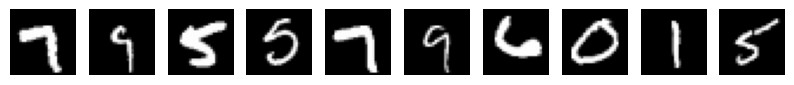

In [ ]:
start = np.random.randint (0, 60000)

plt.figure (figsize = (10,20), dpi = 100)
for i in range(10):
  plt.subplot (1, 10, i+1)
  plt.imshow (train_img[start + i,:,:,0], cmap = "gray")
  plt.axis ("off")
plt.show()

To help the neural networks to consume data efficiently during the training procedure, it's useful prepare it within [`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset).

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 64

In [ ]:
train_ds = ( 
  tf.data.Dataset.from_tensor_slices ( train_img )
  .shuffle ( BUFFER_SIZE )                       # shuffle all the images
  .batch ( BATCH_SIZE, drop_remainder = True )   # mini-batch splitting
  .cache()                                       # cache the dataset
  #.prefetch ( tf.data.AUTOTUNE )   # pre-prepare data to be consumed
)

test_ds = ( 
  tf.data.Dataset.from_tensor_slices ( test_img )
  .shuffle ( BUFFER_SIZE )                       # shuffle all the images
  .batch ( BATCH_SIZE, drop_remainder = True )   # mini-batch splitting
  .cache()                                       # cache the dataset
  #.prefetch ( tf.data.AUTOTUNE )   # pre-prepare data to be consumed
)

### Create the adversarial players

Both the generator and the discriminator are defined using the [Keras Sequential API](https://www.tensorflow.org/guide/keras/sequential_model).

#### The generator

The generator uses [`tf.keras.layers.Conv2DTranspose`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose) (sometimes called **deconvolutional**) layers to produce an image from the latent space $\mathcal{Z}$. Start with a `Dense` layer that takes $z$ elements as input, then upsample several times until to reach the desired image size of 28x28x1. Notice the [`tf.keras.layers.LeakyReLU`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LeakyReLU) activation for each layer, except the output layer which uses $\tanh$.

In [ ]:
LATENT_DIM = 100

<center>$G : \mathcal{N}_{(0,1)}^{100} \to (-1,1)^{28} \times (-1,1)^{28}$</center>

In [ ]:
generator = Sequential ( name = "generator" )

generator . add ( layers.Dense ( 7 * 7 * 256, use_bias = False, input_shape = (LATENT_DIM,) ) )
generator . add ( layers.BatchNormalization() )
generator . add ( layers.LeakyReLU() )

generator . add ( layers.Reshape ( (7, 7, 256) ) )

generator . add ( layers.Conv2DTranspose ( 256, (3, 3), strides = (1, 1), padding = "valid" ) )
generator . add ( layers.BatchNormalization ( axis = 1 ) )
generator . add ( layers.LeakyReLU() )

generator . add ( layers.Conv2DTranspose ( 128, (4, 4), strides = (2, 2), padding = "valid" ) )
generator . add ( layers.BatchNormalization ( axis = 1 ) )
generator . add ( layers.LeakyReLU() )

generator . add ( layers.Conv2DTranspose ( 64, (5, 5), strides = (1, 1), padding = "valid" ) )
generator . add ( layers.BatchNormalization ( axis = 1 ) )
generator . add ( layers.LeakyReLU() )

generator . add ( layers.Conv2DTranspose ( 1, (5, 5), strides = (1, 1), padding = "valid", activation = "tanh" ) )

Use the (as yet untrained) generator to create an image.

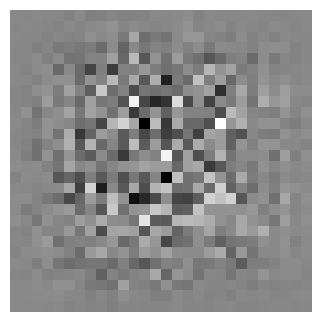

In [ ]:
z = tf.random.normal ( shape = [1, 100] )
gen_image = generator ( z, training = False )

plt.figure (figsize = (4,4), dpi = 100)
plt.imshow (gen_image[0, :, :, 0], cmap = "gray")
plt.axis ("off")
plt.show()

#### The discriminator

The discriminator is a CNN-based image classifier. 

<center>$D : (-1,1)^{28} \times (-1,1)^{28} \to \mathbb{R}$</center>

In [ ]:
discriminator = Sequential ( name = "discriminator" )
    
discriminator . add ( layers.Conv2D ( 32, (4, 4), strides = (2, 2), padding = "same", input_shape = [28, 28, 1] ) )
discriminator . add ( layers.BatchNormalization ( axis = 1 ) )
discriminator . add ( layers.LeakyReLU ( alpha = 0.2 ) )

discriminator . add ( layers.Conv2D ( 64, (4, 4), strides = (2, 2), padding = "same" ) )
discriminator . add ( layers.BatchNormalization ( axis = 1 ) )
discriminator . add ( layers.LeakyReLU ( alpha = 0.2 ) )

discriminator . add ( layers.Conv2D ( 128, (4, 4), strides = (2, 2), padding = "same" ) )
discriminator . add ( layers.BatchNormalization ( axis = 1 ) )
discriminator . add ( layers.LeakyReLU ( alpha = 0.2 ) )

discriminator . add ( layers.Flatten() )
discriminator . add ( layers.Dense ( 1, activation = "linear" ) )

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output the probability that the input is a real image.

In [ ]:
discriminator ( gen_image ) . numpy()

array([[-3.990573e-05]], dtype=float32)

### Training procedure

The training procedure is implemented through the `WGAN` class provided by the [`tf-gen-models` package](https://pypi.org/project/tf-gen-models/). The network learning is driven by the loss function previously described, while the _discriminator lipschitzianity_ is guaranteed constraining its weights in a compact space [[3](https://arxiv.org/abs/1701.07875)].

In [ ]:
gan = WGAN (generator, discriminator, latent_dim = LATENT_DIM)

The architecture chosen for the two players can be recovered through the `summary()` method.

In [ ]:
gan . summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 9, 9, 256)         590080    
_________________________________________________________________
batch_normalization_1 (Batch (None, 9, 9, 256)         36        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 9, 9, 256)         0 

#### Generator and discriminator optimizers

The discriminator and the generator **optimizers** are different since we will train two networks separately (even if simultaneously).

In [ ]:
g_opt = tf.keras.optimizers.RMSprop ( 5e-5 )
d_opt = tf.keras.optimizers.RMSprop ( 5e-5 )

The `compile()` method of the `WGAN` class allows to choose the number of updates that each players perform once per batch during the training procedure: `g_updt_per_batch` and `d_updt_per_batch`. Since we want a robust discriminator able to give valuable feedbacks to the generator for its updates, the role of these hyperparameters is crucial. Anyway, be careful to avoid imbalance!

In addition, the `compile()` method allows to define the borders of the **clipping box** for the discriminator weights through `clip_param`.

In [ ]:
gan . compile ( g_optimizer = g_opt , 
                d_optimizer = d_opt , 
                g_updt_per_batch = 1 , 
                d_updt_per_batch = 5 ,
                clip_param = 1e-2 )

In order to reach the minimum _quickly_ and _safely_, the learning rate should be decreased gradually during the training. The `GanLrScheduler` class implements an **exponential decay**, where `factor` represents the decay rate and `step` corresponds to the decay step.

In [ ]:
lr_sched = GanExpLrScheduler ( factor = 0.90, step = 5 )

#### Custom callbacks

A callback is a powerful tool to customize the behavior of a Keras model during training, evaluation, or inference. For instance, the `GanLrScheduler` class mentioned above inherits from the [`tf.keras.callbacks.Callback`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback) class. The `tf-gen-models` package offers more callbacks to customize the training procedure, like `ImageSaver`, `ModelSaver` and `CheckpointPrinter`:

* `ImageSaver` allows to save the generator output (more precisely, a 4x4 matrix of digit images) once every `step` epochs;
* `ModelSaver` allows to save a checkpoint of the generator and/or discriminator models once every `step` epochs.
* `CheckpointPrinter` prints the training status once every `step` epochs.

To learn more about custom callbacks, refers to the [TensorFlow guide](https://www.tensorflow.org/guide/keras/custom_callback).

In [ ]:
img_saver = ImageSaver ( name = "dc-wgan", dirname = "./images/dc-wgan", step = 1, look = "multi" )

In [ ]:
mod_saver = ModelSaver ( name = "dc-wgan", dirname = "./models", step = 10 )

In [ ]:
ckp_printer = CheckpointPrinter ( step = 5 )

#### Minimax game

The `WGAN` class inherits from the [`tf.keras.Model`](https://www.tensorflow.org/api_docs/python/tf/keras/Model) and implements a [custom `fit()` function](https://keras.io/guides/customizing_what_happens_in_fit/). Calling the `fit()` method, every mini-batch of data the discriminator loss function is computed and network weights updated for `d_updt_per_batch` times, then the generator loss is computed and relative weights updated for `g_updt_per_batch` times. Note, training GANs can be _tricky_. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 30 epochs, they resemble MNIST digits. This may take about 4 minutes / epoch with the default settings on [Google Colab](https://colab.research.google.com/).

In [ ]:
EPOCHS = 50
STEPS_PER_EPOCH = int ( len(train_img) / BATCH_SIZE )

In [ ]:
train = gan . fit ( train_ds , 
                    epochs = EPOCHS ,
                    steps_per_epoch = STEPS_PER_EPOCH ,
                    validation_data = test_ds ,
                    callbacks = [ lr_sched, img_saver, mod_saver, ckp_printer ] ,
                    verbose = 0 )

2022-02-03 21:59:09.026751 | Begin of the training procedure


2022-02-03 21:59:12.211136: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


2022-02-03 22:06:30.288650 | Epoch: 5 | mse: 6.00e-01 - d_loss: -2.24e+02 - g_loss: 2.24e+02 - d_lr: 4.60e-05 - g_lr: 4.60e-05 - val_mse: 5.87e-01 - val_d_loss: 1.77e+00 - val_g_loss: -1.77e+00 - val_d_lr: 4.60e-05 - val_g_lr: 4.60e-05 |


2022-02-03 22:13:49.185405: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


2022-02-03 22:13:51.319264 | Epoch: 10 | mse: 5.98e-01 - d_loss: 1.26e+04 - g_loss: -1.26e+04 - d_lr: 4.14e-05 - g_lr: 4.14e-05 - val_mse: 5.84e-01 - val_d_loss: 2.42e+04 - val_g_loss: -2.42e+04 - val_d_lr: 4.14e-05 - val_g_lr: 4.14e-05 |
2022-02-03 22:22:03.130842 | Epoch: 15 | mse: 6.00e-01 - d_loss: 5.97e+03 - g_loss: -5.97e+03 - d_lr: 3.72e-05 - g_lr: 3.72e-05 - val_mse: 5.88e-01 - val_d_loss: -6.52e+03 - val_g_loss: 6.52e+03 - val_d_lr: 3.72e-05 - val_g_lr: 3.72e-05 |
2022-02-03 22:29:24.877400 | Epoch: 20 | mse: 5.80e-01 - d_loss: 5.70e+03 - g_loss: -5.70e+03 - d_lr: 3.35e-05 - g_lr: 3.35e-05 - val_mse: 5.75e-01 - val_d_loss: 6.05e+03 - val_g_loss: -6.05e+03 - val_d_lr: 3.35e-05 - val_g_lr: 3.35e-05 |
2022-02-03 22:36:43.933176 | Epoch: 25 | mse: 5.40e-01 - d_loss: 2.36e+03 - g_loss: -2.36e+03 - d_lr: 3.02e-05 - g_lr: 3.02e-05 - val_mse: 5.50e-01 - val_d_loss: 2.11e+03 - val_g_loss: -2.11e+03 - val_d_lr: 3.02e-05 - val_g_lr: 3.02e-05 |
2022-02-03 22:44:06.052004 | Epoch: 30 | mse

#### Learning and metric curves

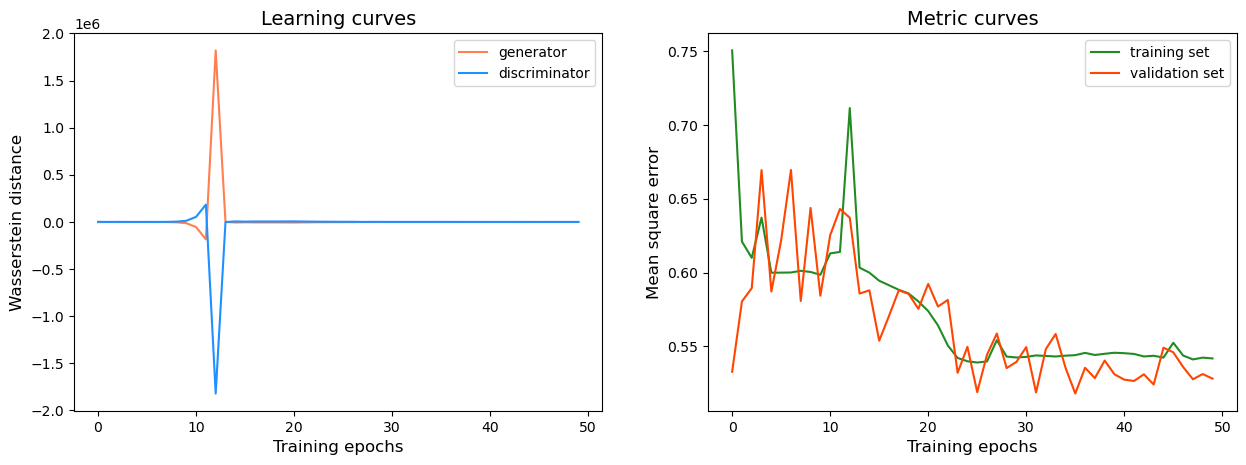

In [ ]:
fig, ax = plt.subplots (1, 2, figsize = (15,5), dpi = 100)
plt.subplots_adjust (wspace = 0.2)

ax[0] . set_title ("Learning curves", fontsize = 14)
ax[0] . set_xlabel ("Training epochs", fontsize = 12)
ax[0] . set_ylabel (f"{gan.loss_name}", fontsize = 12)
ax[0] . plot (train.history["g_loss"], linewidth = 1.5, color = "coral", label = "generator")
ax[0] . plot (train.history["d_loss"], linewidth = 1.5, color = "dodgerblue", label = "discriminator")
ax[0] . legend (loc = "upper right", fontsize = 10)

ax[1] . set_title ("Metric curves", fontsize = 14)
ax[1] . set_xlabel ("Training epochs", fontsize = 12)
ax[1] . set_ylabel ("Mean square error", fontsize = 12)
ax[1] . plot (train.history["mse"], linewidth = 1.5, color = "forestgreen", label = "training set")
ax[1] . plot (train.history["val_mse"], linewidth = 1.5, color = "orangered", label = "validation set")
ax[1] . legend (loc = "upper right", fontsize = 10)

plt.show()

#### Create a GIF

In [ ]:
# Display a single image using the epoch number
def display_image (epoch):
  return PIL.Image.open (f"./images/dc-wgan/dc-wgan_ep{epoch:04d}.png")

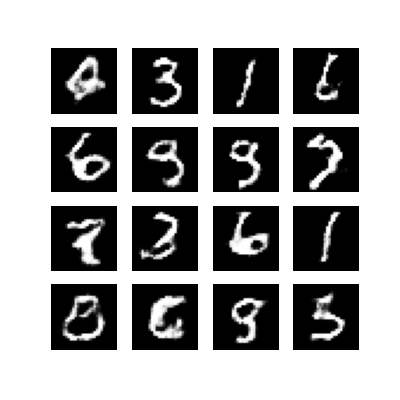

In [ ]:
display_image (EPOCHS)   # last 16 images generated

Use `PIL` to create an animated gif using the images saved during training.

In [ ]:
anim_file = "./images/dc-wgan.gif"

filenames = glob.glob ("./images/dc-wgan/dc-wgan_ep*.png")
filenames = sorted (filenames)

img , *imgs = [ PIL.Image.open(f) for f in filenames ]
img . save ( fp = anim_file, format = "GIF", append_images = imgs,
             save_all = True, duration = 135, loop = 0 )


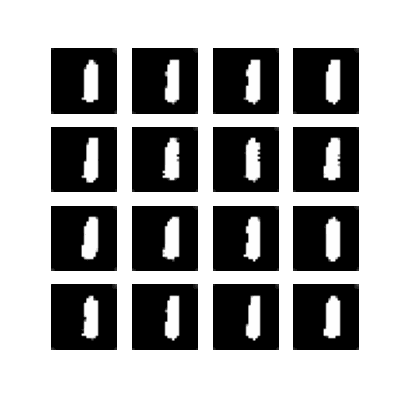

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file (anim_file)

## Next steps

To learn more about GANs see the [notebooks](https://github.com/mbarbetti/tf-gen-models/tree/main/notebooks) section of the `tf-gen-models` [GitHub repository](https://github.com/mbarbetti/tf-gen-models).

## References

1.  I. J. Goodfellow _et al._, "Generative Adversarial Nets", [arXiv:1406.2661](https://arxiv.org/abs/1406.2661).
2. M. Arjovsky and L. Bottou, "Towards Principled Methods for Training Generative Adversarial Networks", [arXiv:1701.04862](https://arxiv.org/abs/1701.04862).
3. M. Arjovsky, S. Chintala and L. Bottou, "Wasserstein GAN", [arXiv:1701.07875](https://arxiv.org/abs/1701.07875).
4. C. Villani, "[Optimal Transport: Old and New](https://link.springer.com/book/10.1007/978-3-540-71050-9)", Grundlehren der mathematischen Wissenschaften, Springer, Berlin, 2009.
5. A. Brock, J. Donahue and K. Simonyan, "Large Scale GAN Training for High Fidelity Natural Image Synthesis", [arXiv:1809.11096](https://arxiv.org/abs/1809.11096).
6. A. Radford, L. Metz and S. Chintala, "Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks", [arXiv:1511.06434](https://arxiv.org/abs/1511.06434).